In [1]:
from segment_anything import SamPredictor, sam_model_registry,SamAutomaticMaskGenerator

In [2]:


import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:

img = cv2.imread("pizza_with_spoon.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


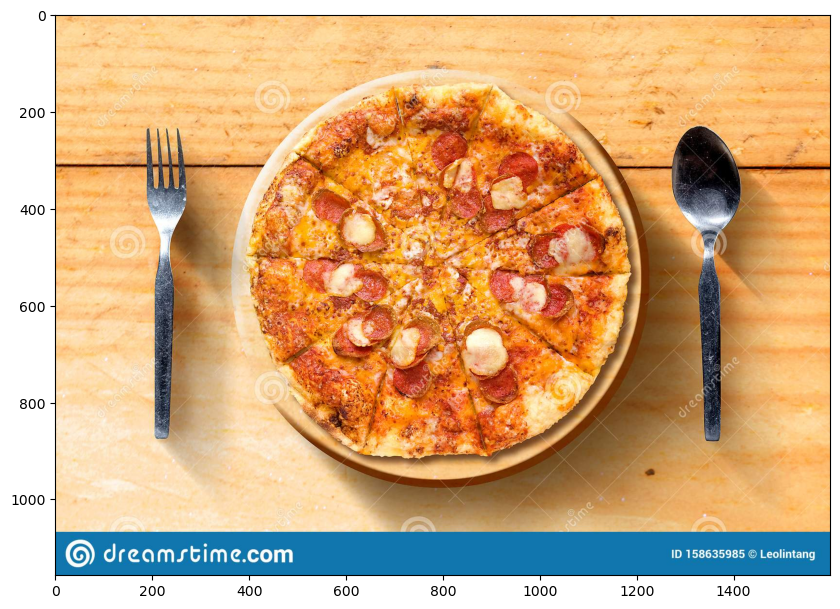

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('on')
plt.show()

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

predictor = SamPredictor(sam)

In [6]:
predictor.set_image(img)


In [44]:
input_point = np.array([[800,500]])
input_label = np.array([1])

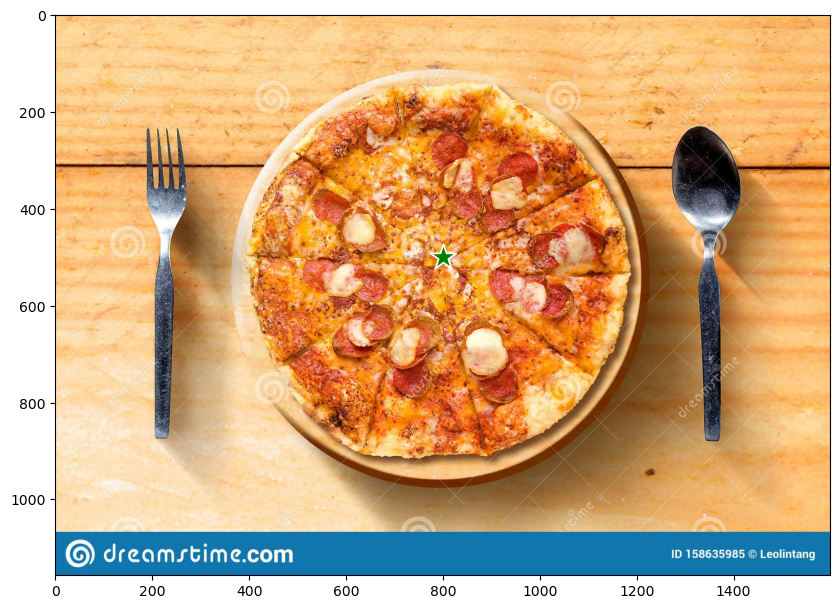

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [46]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


In [47]:
print(img.shape)
print(masks.shape)

(1157, 1600, 3)
(3, 1157, 1600)


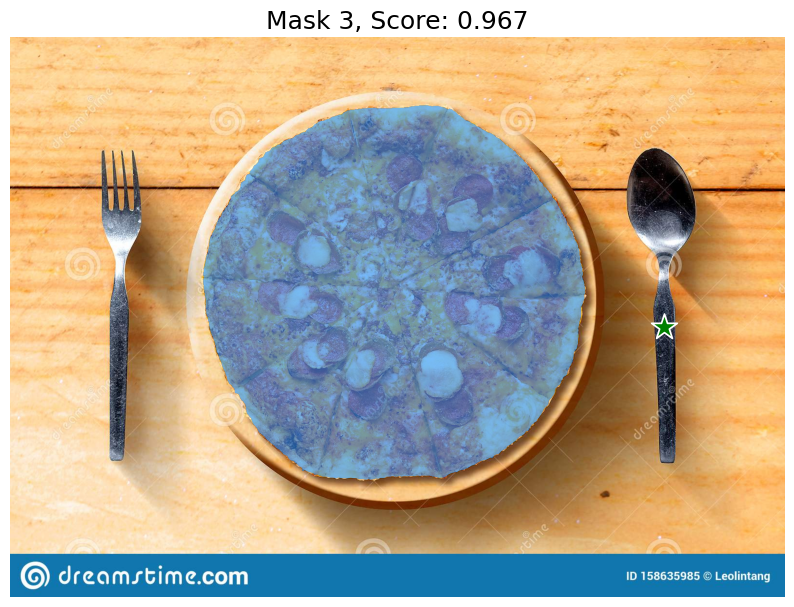

In [72]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Your existing code for generating and highlighting masks
# ...

# Function to resize the mask
def resize_mask(mask, new_size=(256, 256)):
    mask_img = Image.fromarray((mask * 255).astype(np.uint8))
    resized_mask = mask_img.resize(new_size)
    plt.imshow(resized_mask)
    return np.array(resized_mask) / 255

# resize_mask()
# Function to overlay the mask onto a white background


ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

In [ ]:

def overlay_mask_on_white_bg(img, mask, img_size=(256, 256)):
    # Create a white background image
    white_bg = Image.new('RGBA', img_size, (255, 255, 255, 255))

    # Resize the mask and convert it to a boolean array
    resized_mask = resize_mask(mask).astype(bool)

    # Resize the input image
    img_resized = img.resize(img_size)

    # Create a blank image with the same size as the input image
    masked_img = Image.new('RGBA', img_size)

    # Paste the input image onto the blank image using the resized mask as a mask
    masked_img.paste(img_resized, (0, 0), Image.fromarray((resized_mask * 255).astype(np.uint8)))

    # Paste the masked image onto the white background
    white_bg.paste(masked_img, (0, 0), masked_img)

    return white_bg.convert('RGB')

# Iterate over the masks and create separate images
for i, (mask, score) in enumerate(zip(masks, scores)):
    # Overlay the resized mask onto the white background
    masked_img = overlay_mask_on_white_bg(img, mask)
    
    # Save the masked image to a file
    masked_img.save(f"mask_{i + 1}.png")


In [54]:
print(masks[0])

IndexError: index 500 is out of bounds for axis 0 with size 3

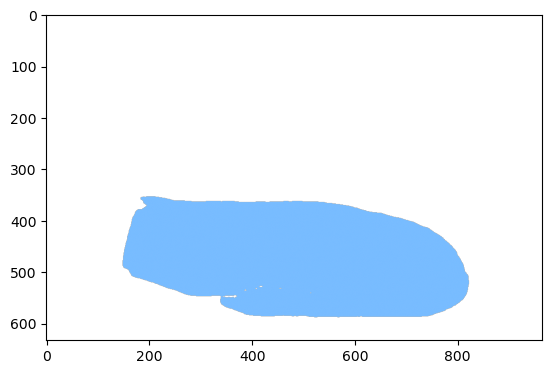

In [59]:
mask = masks[2]
h, w = mask.shape[-2:]
color = np.array([30/255, 144/255, 255/255, 0.6])
mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.imshow(mask_image)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def apply_mask_on_image(img, mask):
    # Ensure the mask is a boolean array
    mask = mask.astype(bool)

    # Create a white image with the same shape as the input image
    white_bg = np.full(img.shape, 255, dtype=np.uint8)

    # Apply the mask to the input image by combining the masked area with the white background
    masked_img = np.where(mask[..., np.newaxis], img, white_bg)

    return masked_img
def resize_image_aspect_ratio(img_np, max_size=(256, 256)):
    img = Image.fromarray(img_np)
    img.thumbnail(max_size)
    return np.array(img)
def resize_image(img_np, new_size=(256, 256)):
    img = Image.fromarray(img_np)
    img_resized = img.resize(new_size)
    return np.array(img_resized)

(185, 256, 3)


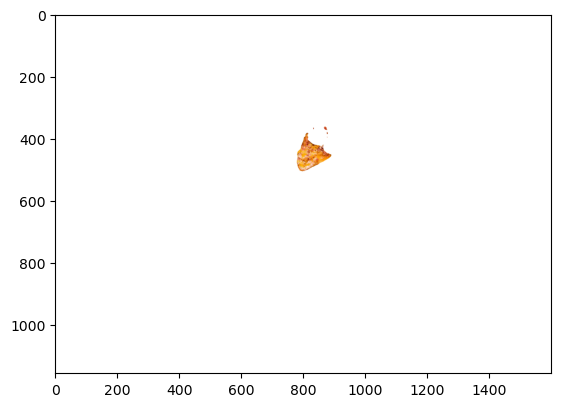

(185, 256, 3)


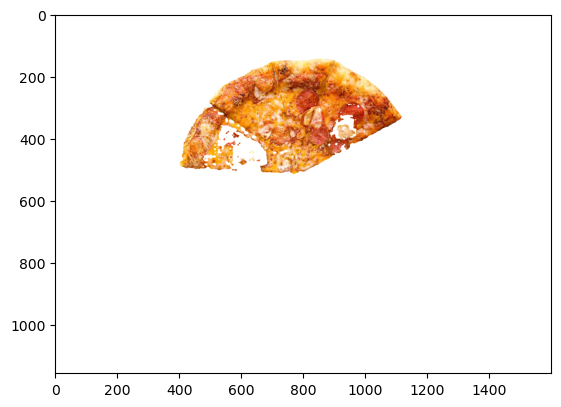

(185, 256, 3)


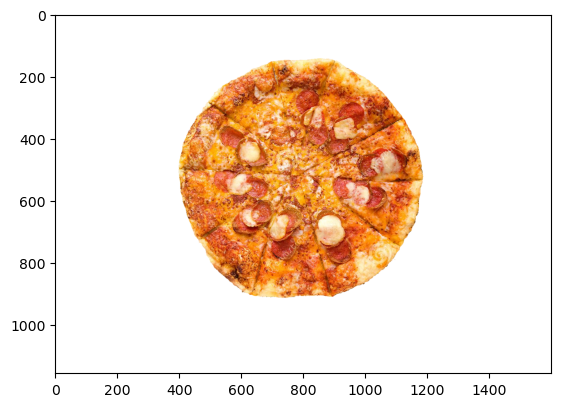

In [18]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    masked_img = apply_mask_on_image(img, mask)
    resized_masked_img = resize_image_aspect_ratio(masked_img, max_size=(256, 256))
    print(resized_masked_img.shape)
    plt.imsave(f"pizza_with_spoon_masked_image_{i + 1}.png", resized_masked_img)
    plt.imshow(masked_img)
    plt.show()


In [20]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [21]:
mask_generator = SamAutomaticMaskGenerator(sam)


In [22]:
new_masks = mask_generator.generate(img)


In [23]:
print(len(new_masks))
print(new_masks[0].keys())

60
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


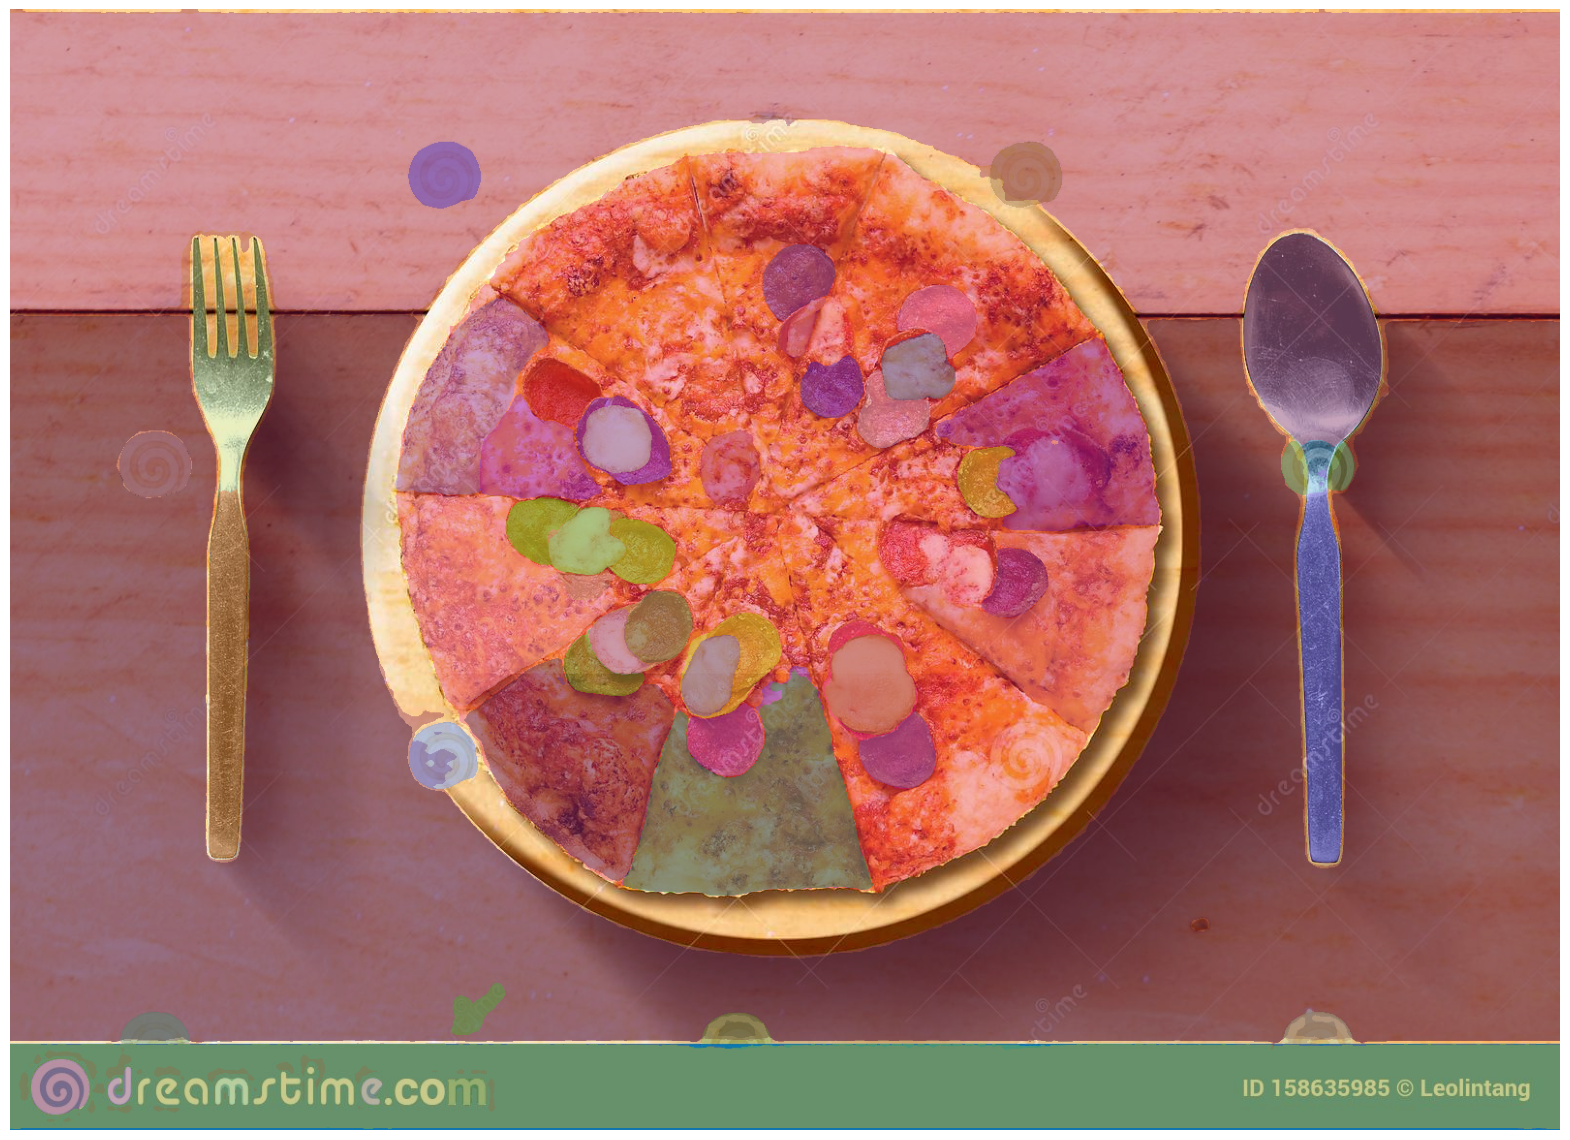

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(new_masks)
plt.axis('off')
plt.show() 


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from PIL import Image

# Load the pre-trained ResNet-50 model
model = ResNet50(weights='imagenet')

# Load the generated image
image_file = "pizza_with_spoon_masked_image_3.png"  # Replace this with the file name of your generated image
image = Image.open(image_file)

# Resize and preprocess the image
image = image.convert('RGB')
image = image.resize((224, 224))  # ResNet-50 expects input images to be 224x224
image_np = np.array(image)
image_np = preprocess_input(image_np)
image_np = np.expand_dims(image_np, axis=0)

# Make a prediction
predictions = model.predict(image_np)

# Decode and print the predictions
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Top 3 predictions:")
for i, (class_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}. {label} ({score:.2f})")


2023-04-17 15:18:48.390259: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 15:18:50.342530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 15:18:54.548660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-17 15:19:02.712779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


1/1 [==============================] - 2s 2s/step
Top 3 predictions:
1. potpie (0.16)
2. pizza (0.12)
3. waffle_iron (0.10)


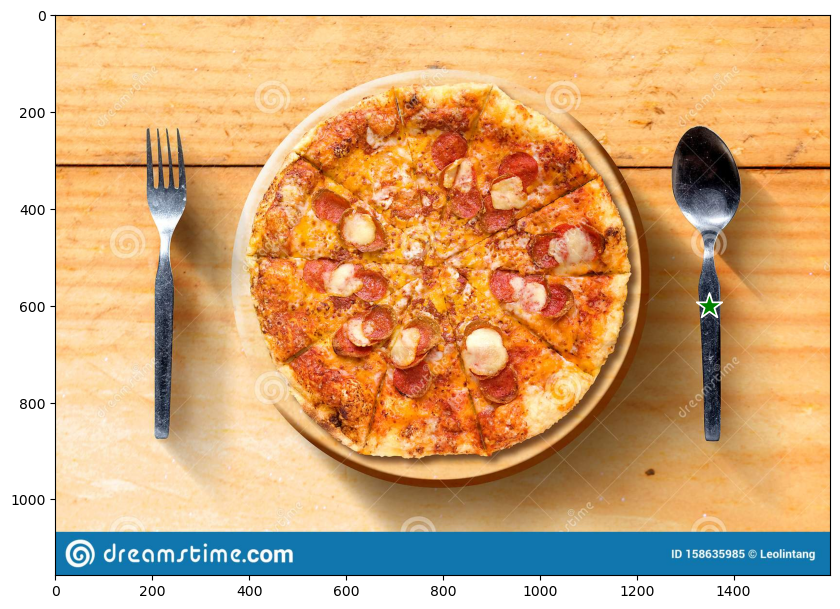

In [49]:
input_point = np.array([[1350,600]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [50]:
spoon_masks, spoon_scores, spoon_logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print(img.shape)
print(masks.shape)

(1157, 1600, 3)
(3, 1157, 1600)


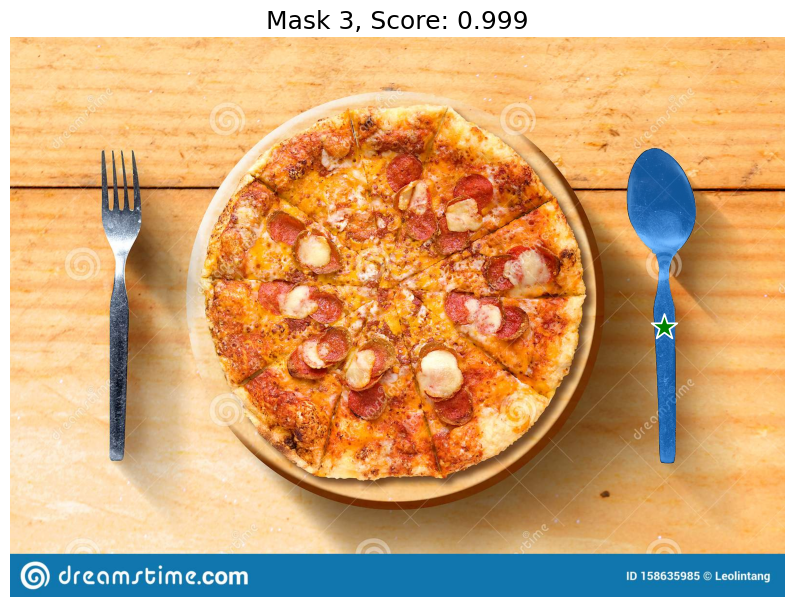

In [74]:
# for i, (mask, score) in enumerate(zip(spoon_masks, spoon_scores)):
mask = spoon_masks[2]
score = spoon_scores[2]
plt.figure(figsize=(10,10))
plt.imshow(img)
show_mask(mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
plt.axis('off')
plt.show()  

In [52]:
spoon_masks[2][600][215]

False

In [60]:
def get_max_length_breadth(arr):
    rows = len(arr)
    cols = len(arr[0])
    max_length = 0
    max_breadth = 0
    memo = [[None for _ in range(cols)] for _ in range(rows)]

    def get_object_length_breadth(i, j):
        # Check if we have already calculated the length and breadth for this object
        if memo[i][j] is not None:
            return memo[i][j]

        # Find the length and breadth of the object starting from this element
        length = 1
        breadth = 1
        k = j+5
        while k < cols and arr[i][k]:
            length += 5
            k += 5
        k = i+5
        while k < rows and arr[k][j]:
            breadth += 5
            k += 5

        # Update the maximum length and breadth
        nonlocal max_length, max_breadth
        max_length = max(max_length, length)
        max_breadth = max(max_breadth, breadth)

        # Memoize the length and breadth for this object
        for k in range(i, i+breadth):
            for l in range(j, j+length):
                memo[k][l] = (length, breadth)

        return (length, breadth)

    # Iterate through each element of the array
    for i in range(rows):
        for j in range(cols):
            if arr[i][j]:  # If the element is True
                # Find the length and breadth of the object starting from this element
                length, breadth = get_object_length_breadth(i, j)

    return (max_length, max_breadth)


In [61]:
max_length,max_breadth = get_max_length_breadth(spoon_masks[2])

In [62]:
max_length_pizza,max_breadth_pizza = get_max_length_breadth(masks[2])

In [65]:
print(max_length, max_breadth, max_length_pizza, max_breadth_pizza)

141 641 786 766


In [68]:
length_of_1_pixel = 16.5/max_breadth
length_of_1_pixel_byBreath = 3.6/max_length

print(length_of_1_pixel,length_of_1_pixel_byBreath) #Can tell us about its error rate

0.02574102964118565 0.025531914893617023


In [69]:
length_of_pizza = length_of_1_pixel*max_breadth_pizza
breadth_of_pizza = length_of_1_pixel*max_length_pizza
print(length_of_pizza, breadth_of_pizza)

19.717628705148208 20.232449297971918


In [71]:
!python --version

Python 3.9.13
